In [88]:
import numpy as np
import datasets
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


First thing we are going to do is to just load our data in. The data when being put through a TensorFlow should be organized in a very specific way. Right now each observation in our data is organized like this : $(2\cdot M,K,L)$

- $M$ = 100; Batch number, remember each batch observation is 2 tensors each one correlating to the left/right audio channel.
- $K$ = 40; Index/number of overlapping chunks of waveform.
- $L$ = 16; Length of a chunk/sample of data. For this study we will refer to these as chunks.

For our outputs the data is structured like: $(2\cdot M,C,K,L)$

- $C$ = 4; Denotes the source target.

In [89]:
tf_data = tf.data.Dataset.load('tensors/tensor_dataset_small')
tf_data

<_LoadDataset element_spec=(TensorSpec(shape=(200, 40, 16), dtype=tf.float32, name=None), TensorSpec(shape=(200, 4, 40, 16), dtype=tf.float32, name=None))>

In [90]:
x_batches = [tens[0] for tens in tf_data]
y_batches = [tens[1] for tens in tf_data]

In [91]:
x_batches = np.array(x_batches)
y_batches = np.array(y_batches)

In [92]:
type(x_batches[0][1])

numpy.ndarray

In [93]:
x_batches[0].shape

(200, 40, 16)

In [104]:
# Params as globals for testing purposes

L=16 # Chunk size
C=4 # Amount of sources being estimated
N=512 # Encoder output size
B=128 # Conv1DBlock output size
H=512 # Conv1DBlock input size
P=3
R=3 # Amount of repeats of the Temporal Convolution block
X=8 # Amount of times Conv1DBlock is applied in a Temporal Convolution block
T=3000 # TODO: figure out how to get this param
dilation = 1
overlap=8
casual=False

## Overall Architecture

Looking at the model from a top down view, the data follows this pipeline:

Data ---> Encoder ----> Separator ---> Decoder ---> Create Sources

In [ ]:
class ConvTasNet(models.Model):
    """
    
    """
    def __init__(self,
                 L: int=16, # Chunk size
                 C: int=4, # Amount of sources being estimated
                 N: int=512, # Encoder output size
                 B: int=128, # Conv1DBlock output size
                 H: int=512, # Conv1DBlock input size
                 P: int=3, # Kernel size of Conv1DBlocks
                 R: int=3, # Amount of repeats of the Temporal Convolution block
                 X: int=8, # Amount of times Conv1DBlock is applied in a Temporal Convolution block
                 T: int=3000, # TODO: figure out how to get this param
                 overlap: int=8,
                 casual: bool=False
                ):
        self.L = L
        self.C = C
        self.N = N
        self.B = B
        self.H = H
        self.R = R
        self.X = X
        self.T = T
        self.overlap = overlap
        self.casual = casual


        self.encoder = Encoder(self.N)
        self.separator = Separator(self.N, self.B, self.R, self.X, self.H, self.C, self.casual)
        self.decoder = Decoder(self.L)

    def call(self, x):
        w = self.encoder(x)
        m_i = self.separator(w)

        est_sources = self.decoder(w, m_i)

        return est_sources


In [123]:
class Encoder(layers.Layer):
    """ 
    First step of model not counting, preprocessing data. Puts the inputs through a 1x1 Convolutional layer with N output channels.
    A 1x1Convolutional layer can be interpreted and implemented as a Dense layer, but I chose not to implement it this way for clarity.
    The layer also has a ReLU activation function attached to it.

    Args: 
        N: Encoder output size

    """
    def __init__(self, N):
        super(Encoder, self).__init__(name='Encoder')
        self.U = layers.Conv1D(N, 1, activation='relu')

    def call(self, x): # (M, K, L)
        return self.U(x) # (M, K, N)

        
class Separator(layers.Layer):
    """ 
    To begin the we take the output of the encoder which we then normalize it and feed it into a 1x1Convolution.
    This layer repeats a Temporal Convolution Block multiple times, wherin, what is refered to as a Conv1D Block in the paper, is repeated
    several times for each instance of a Temporal Convolutional Block. Finally the output of the Temporal blocks is input into a 1x1 Convolution
    with C*N output channels.
    Args:
        N: (int) Encoder output size
        B: (int) Conv1DBlock output size
        R: (int) Amount of repeats of the Temporal Convolution block
        X: (int) Amount of times Conv1DBlock is applied in a Temporal Convolution block
        H: (int) Conv1DBlock input size
        C: (int) Amount of sources being estimated
    
    """
    def __init__(self, N, B, R, X, H, C, P, casual):
        super(Separator, self).__init__(name='Separator')
        
        if casual:
            self.normalization = cLN(N)
        else:
            self.normalization = gLN(N) 
        self.bottle_neck = layers.Conv1D(B,1)
        
        self.temporal_conv = [TemporalConv(X, H, B, P, casual) for r in range(R)]
        self.m_i = layers.Conv1D(C*N, 1, activation='relu')

    def call(self, w): # (M, K, N)
        normalized_w = self.normalization(w) # (M, K, N)
        block_inputs = self.bottle_neck(normalized_w) # (M, K, B)
        for i,block in enumerate(self.temporal_conv):
            if i == 0:
                temporal_outputs = block(block_inputs)
            else:
                temporal_outputs = block(temporal_outputs)
        # (M, K, B)

        estimated_masks = self.m_i(temporal_outputs)# (M, K, C*N)
        return estimated_masks
    
class Decoder(layers.Layer):
    """ 
    This is layer is final part of the model. Taking the features obtained, from the Conv1D blocks masks are finally combined into with the
    original mix into the estimated sources.

    Args:
        L : (int) length of individual chunks of audio.
    """
    def __init__(self, L):
        super(Decoder, self).__init__(name='Decoder')
        self.transpose_conv = layers.Conv1DTranspose(L, 1)

    def call(self, M, m_i, w, C, N, L, T, K):
        estimated_sources = mask_mult(w, m_i, C)
        estimated_sources = layers.Reshape((M, C, N, K))(estimated_sources)

        estimated_sources = self.transpose_conv(estimated_sources)

        estimated_sources = overlap_add(estimated_sources)

        return estimated_sources            


In [ ]:
class ConvTasNet(models.Model):
    """
    
    """
    def __init__(self,
                 L: int=16, # Chunk size
                 C: int=4, # Amount of sources being estimated
                 N: int=512, # Encoder output size
                 B: int=128, # Conv1DBlock output size
                 H: int=512, # Conv1DBlock input size
                 P: int=3, # Kernel size of Conv1DBlocks
                 R: int=3, # Amount of repeats of the Temporal Convolution block
                 X: int=8, # Amount of times Conv1DBlock is applied in a Temporal Convolution block
                 T: int=3000, # TODO: figure out how to get this param
                 overlap: int=8,
                 casual: bool=False
                ):
        self.L = L
        self.C = C
        self.N = N
        self.B = B
        self.H = H
        self.R = R
        self.X = X
        self.T = T
        self.overlap = overlap
        self.casual = casual


        self.encoder = Encoder(self.N)
        self.separator = Separator(self.N, self.B, self.R, self.X, self.H, self.C, self.casual)
        self.decoder = Decoder(self.L)

    def call(self, x):
        w = self.encoder(x)
        m_i = self.separator(w)

        est_sources = self.decoder(w, m_i)

        return est_sources


In [9]:
x_batches[0].shape

(200, 40, 16)

In [13]:
w = Encoder(N)(x_batches[1])

In [ ]:
bottle_neck = layers.Conv1D(B,1)(w)
bottle_neck = layers.BatchNormalization

In [119]:
class Conv1DBlock(layers.Layer):
    def __init__(self, H, B, P, dilation, casual):
        super(Conv1DBlock, self).__init__(name='Conv1DBlock')
        self.input_channels = layers.Conv1D(H,1)
        self.prelu = layers.PReLU()
        if casual:
            self.norm = cLN(H)
        else:
            self.norm = gLN(H)
        
        self.depthwise = DepthwiseConv(H, B, P, dilation, casual)

    def call(self, input):
        input_channels = self.input_channels(input)
        input_channels = self.prelu(input_channels)
        input_channels = self.norm(input_channels)

        block_output = self.depthwise(input_channels)
        return block_output

class DepthwiseConv(layers.Layer):
    def __init__(self, H, B, P, dilation, casual):
        super(DepthwiseConv, self).__init__(name='DepthwiseConv')
        if casual:
            padding_type = "casual"
            self.norm = cLN(H)
        else:
            padding_type = "same"
            self.norm = gLN(H)

        self.conv1d = layers.Conv1D(H, P, dilation_rate=dilation, padding=padding_type, groups=H)
        self.prelu = layers.PReLU()
        
        self.conv1x1 = layers.Conv1D(B, 1)
    
    def call(self, input):
        input = self.conv1d(input) 
        input = self.prelu(input)
        input = self.norm(input)
        input = self.conv1x1(input)
        return input

class TemporalConv(layers.Layer):
    def __init__(self, X, H, B, P, casual):
        super(TemporalConv,self).__init__(name='TemporalConv')
        self.blocks = []
        for i in range(X):
            dilation = 2 ** i
            self.blocks += [Conv1DBlock(H, B, P, dilation, casual)]
        
    def call(self, input):
        for block in self.blocks:
            input = block(input)
        return input
        


In [114]:
test_encoded = Encoder(N)(x_batches[0]) # (M, K, N)
test_encoded.shape

TensorShape([200, 40, 512])

In [115]:
norm_test_encoded = gLN(N)(test_encoded) # (M, K, N)
bottle_neck = layers.Conv1D(B,1)(norm_test_encoded) # (M, K, B)
bottle_neck.shape 

TensorShape([200, 40, 128])

In [116]:
convblock_test = Conv1DBlock(H, B, P, dilation, casual)(bottle_neck)
convblock_test.shape

TensorShape([200, 40, 128])

In [120]:
temp_block_test = TemporalConv(X, H, B, P, casual)(bottle_neck)
temp_block_test.shape

TensorShape([200, 40, 128])

In [122]:
mi_test = layers.Conv1D(C*N, 1, activation='relu')(temp_block_test)
mi_test.shape

TensorShape([200, 40, 2048])

In [124]:
sep_test = Separator(N, B, R, X, H, C, P, casual)(test_encoded)
sep_test.shape

TensorShape([200, 40, 2048])

In [ ]:
def choose_norm(casual, H):
    """ 
    Chooses normalization type based on value of casual.

    Args:
        casual: (bool) chooses type of normalization applied.
    Returns:
        cLN or gLN (layer)
    """
    if casual:
        return cLN(H)
    else:
        return gLN(H)

class cLN(layers.Layer):
    def __init__(self, H, EPS = 1e-8):
        super(cLN, self).__init__(name="cLN")
        self.EPS = EPS
        shape = (1,H,1)
        self.gamma = tf.Variable(tf.ones(shape),trainable=True,shape=shape)
        self.beta = tf.Variable(tf.zeros(shape),trainable=True,shape=shape)

    def call(self, input):
        # (M, H, K)
        E_f = tf.math.reduce_mean(input, axis=1, keepdims=True) # (M, 1, K)
        var = tf.math.reduce_variance(input, axis=1, keepdims=True)# (M, 1, K)

        normalized = self.gamma * (input - E_f) / tf.math.sqrt(var + self.EPS) + self.beta
        # (M, H, K)
        return normalized
    
class gLN(layers.Layer):
    def __init__(self, H, EPS = 1e-8):
        super(gLN, self).__init__(name="gLN")
        self.EPS = EPS
        shape = (1,H,1)
        self.gamma = tf.Variable(tf.ones(shape),trainable=True,shape=shape)
        self.beta = tf.Variable(tf.zeros(shape),trainable=True,shape=shape)

    def call(self, input):
        # (M, H, K)
        E_f = tf.math.reduce_mean(input, axis=(1,2), keepdims=True) # (M, 1, 1)
        var = tf.math.reduce_variance(input, axis=(1,2), keepdims=True)# (M, 1, K)

        normalized = self.gamma * (input - E_f) / tf.math.sqrt(var + self.EPS) + self.beta
        # (M, H, K)
        return normalized


In [65]:
def show_norm(input):
    fig, axes = plt.subplots(1,3, figsize=(12, 4))

    norm_c = cLN()(input)
    norm_g = gLN()(input)

    axes[0].set_title("Not normalized")
    axes[0].plot(input[0][0])

    axes[1].set_title("Casual normalization")
    axes[1].plot(norm_c[0][0])

    axes[2].set_title("Global normalization")
    axes[2].plot(norm_g[0][0])


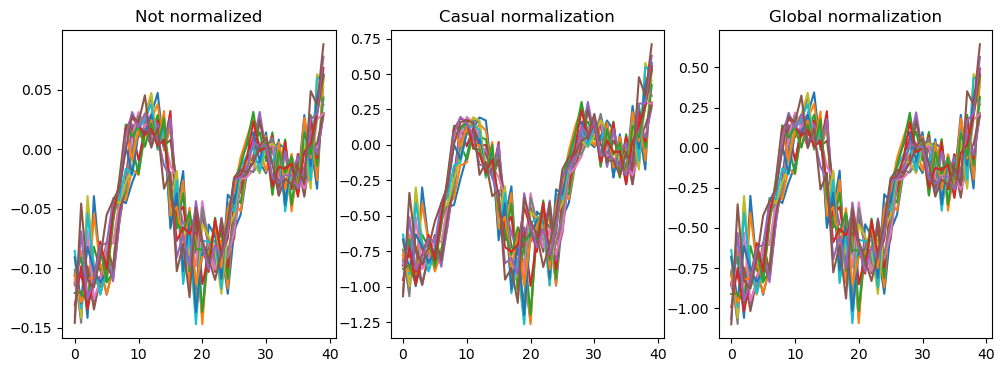

In [66]:
show_norm(x_batches)